# Telco Churn Classification Project

## An Overview
Telco's long-term success weighs upon its customer base. Continuous gains in revenue necessitate a minimization of customers terminating our services. Churn can be triggered by many different factors such as highly incentivized packages from competitors, negative service experiences and change of individual needs are among these. As your faithful data scientist, I will retrieve, assess, and draw conclusions that are not easily detected without the inference provided by machine learning's novel insights. 

## Project Goal
By utilizing some of Python's essential tools for working with data, I will elucidate critical issues and weaknesses. This way,Telco can effectively target potential losses, gaining initiative and resourcefulness beforehand by addressing problem areas as identified by a predictive model.

# The First Stage: Data Acquisition
##### First we tap into Codeup's MySQL database and join all the necessary foreign keys so that all information relevant to this scenario is readily available for analysis.
The tables used, to this end: customers, contract_types, internet_services_types, and payment_types.
The innerworkings of this retrieval are imported from a personalized acquire module. We will now import that among all the other modules relevant to this project. These include Numpy and Pandaz for datawrangling and processing, alongside Matplotlib and Seaborn for the sake of visualization.

In [24]:
# The usual modular suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

# Of Mice & Machine Learning Mavericks
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.dummy import DummyClassifier

# Cool like Jazz; A Few of my Favorite Things 
import env
import os
from acquire import get_telco_data
from prepare import prep_telco_data
from explore import describe_data, plot_target_dist, plot_internet_services, plot_services, plot_services_churn
from explore import plot_contracts, plot_pay_methods, get_churn_heatmap, countplot
from preprocessing import central_limit_theorem_test, two_sample_ttest, equal_var_test, chi2_test, evaluate_hypothesis
from model import model_metrics, baseline_model, model_more

import warnings
warnings.filterwarnings('ignore')

In [11]:
# run the user-defined function (UDF) get_telco_data IOT create a customer-based dataframe
df = get_telco_data()

Using cached csv


# Stage Two: Data Preparation
After acquisition, several steps are carried out to prepare and sanitize it. This step is essential for gaining an understanding of the data's structure. Here we also conduct initial preprocessing, identify patterns and inconsistencies in the data (i.e. missing values) and build and establish some assumptions before getting into the more rigorous ends of hypotheses formulation. 

As such, I've developed a UDF called describe_data that gives me information such as summary statistics, the number of missing values, and relative frequencies among unique values in columns. To this end, I discovered that each new customer with a tenure of zero had white space in their total_charges column, and controlled for this, among other factors via another UDF called prep_telco_data, which can be found in the prepare.py file in my repository. 

In [4]:
describe_data(df)

The first three rows are: 
----------------------------------------------------------
   payment_type_id  internet_service_type_id  contract_type_id customer_id  \
0                2                         1                 2  0002-ORFBO   
1                2                         1                 1  0003-MKNFE   
2                1                         2                 1  0004-TLHLJ   

   gender  senior_citizen partner dependents  tenure phone_service  ...  \
0  Female               0     Yes        Yes       9           Yes  ...   
1    Male               0      No         No       9           Yes  ...   
2    Male               0      No         No       4           Yes  ...   

  tech_support streaming_tv streaming_movies paperless_billing  \
0          Yes          Yes               No               Yes   
1           No           No              Yes                No   
2           No           No               No               Yes   

  monthly_charges total_charges chu

One important distinction: I opted to manually remove a dummy from each of the newly created features among non-dichotomous value sets. Reason being, much of the time, "No Service" was a survivor among the ranks; but due to the low cost loss potentialities, and my immediate interest in peeping into Fibers innermost secrets, elements involving the absence of internet usage were left in the dust. 

In [12]:
train, test, validate = prep_telco_data(df)

Notice here how instead of seeing the variable named df, as it was before, it has now been split into three distinct samples. The target of which is, of course, churn, as it is the dependent feature for this project.

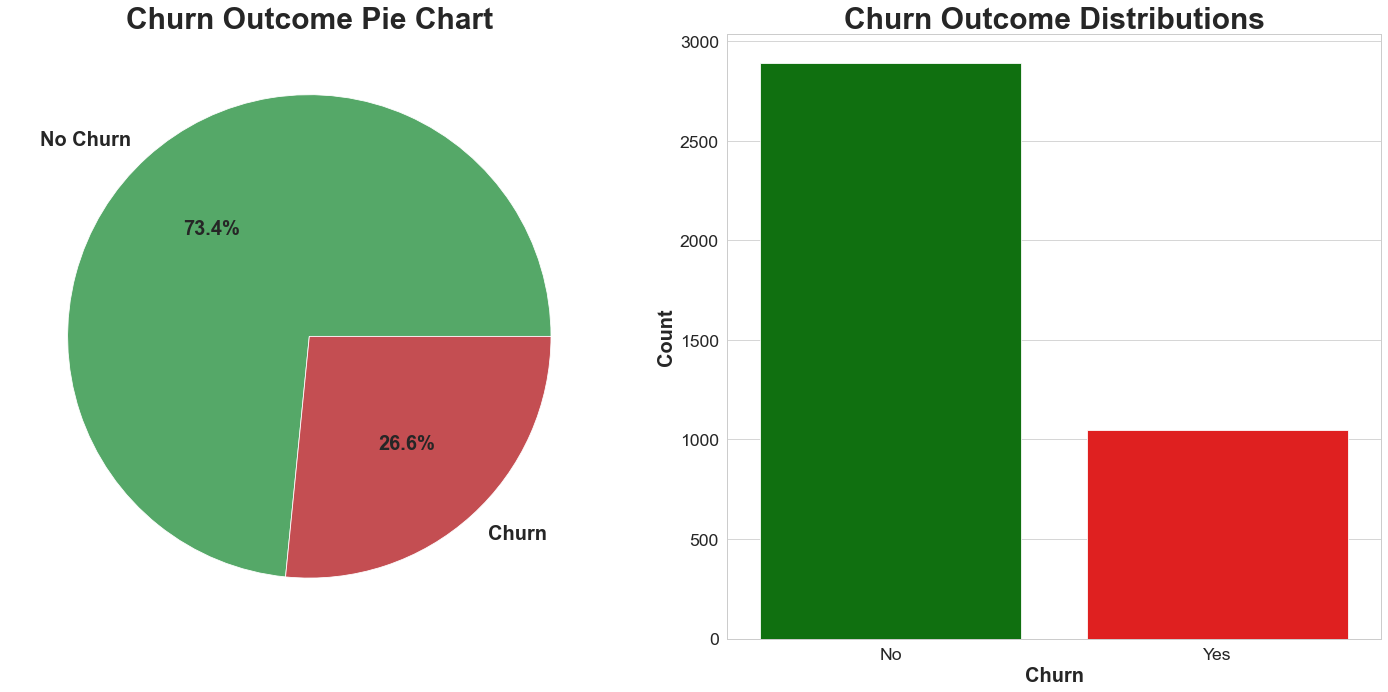

In [5]:
plot_target_dist(train)

***
# Stage Three: Exploratory Analysis

- At this juncture, via visualization we discover which features will have the largest impact on our target variable, churn. Once these are assumed, they are submitted to rigorous statistical tests.    
***
- I effectively skipped ahead to mass representation of bivariate features, since it seemed more practical to visualize the count of a particular independent variable with churn simultaneously visible.      

  - A UDF countplot allowed me to represent each of these in a tight-fit space. After scanning them, I developed a better sense of how to approach hypothesis testing. More on that in a bit.

 <function show at 0x7fcb92e70e50>
 <function show at 0x7fcb92e70e50>


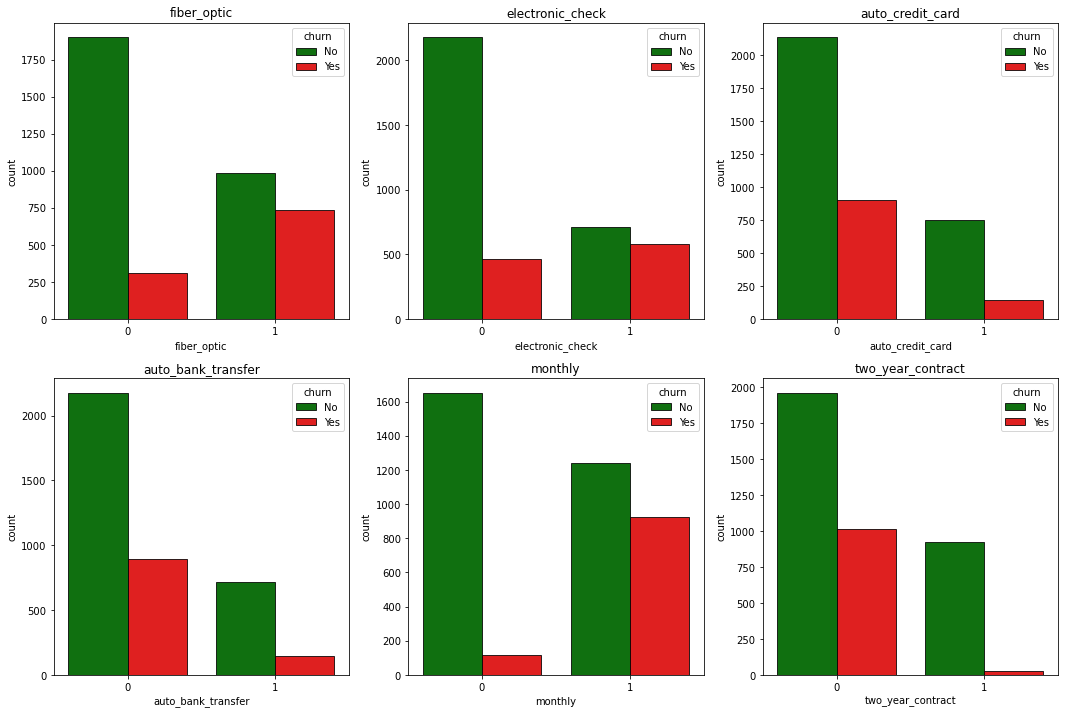

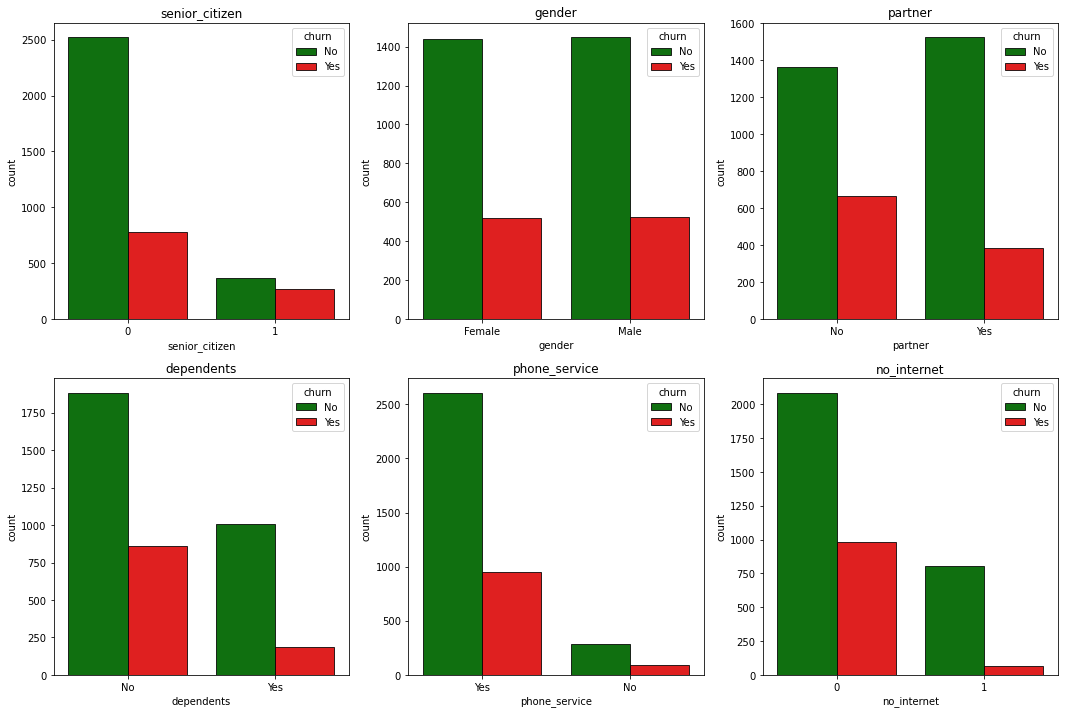

In [13]:
print(f" {countplot('churn', ['fiber_optic', 'electronic_check', 'auto_credit_card', 'auto_bank_transfer', 'monthly', 'two_year_contract'], train)}")
print(f" {countplot('churn', ['senior_citizen', 'gender', 'partner','dependents', 'phone_service', 'no_internet'], train)}")

 <function show at 0x7fcb92e70e50>
 <function show at 0x7fcb92e70e50>
 <function show at 0x7fcb92e70e50>
 I used this as an overview to assess which ones I wish to look more closely at


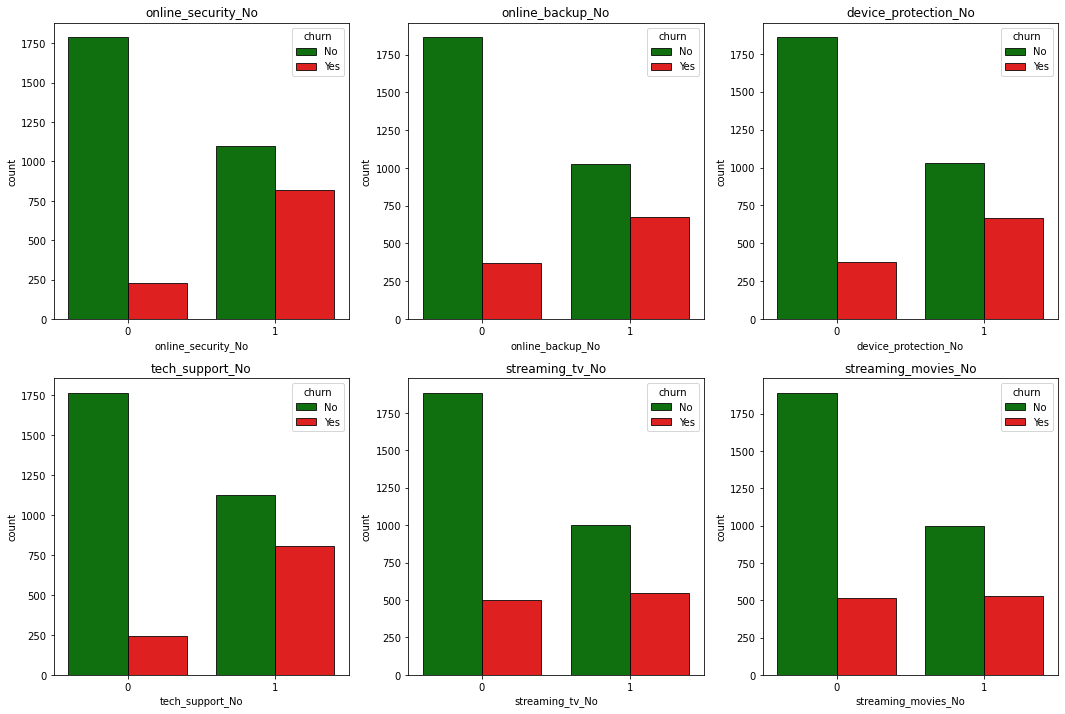

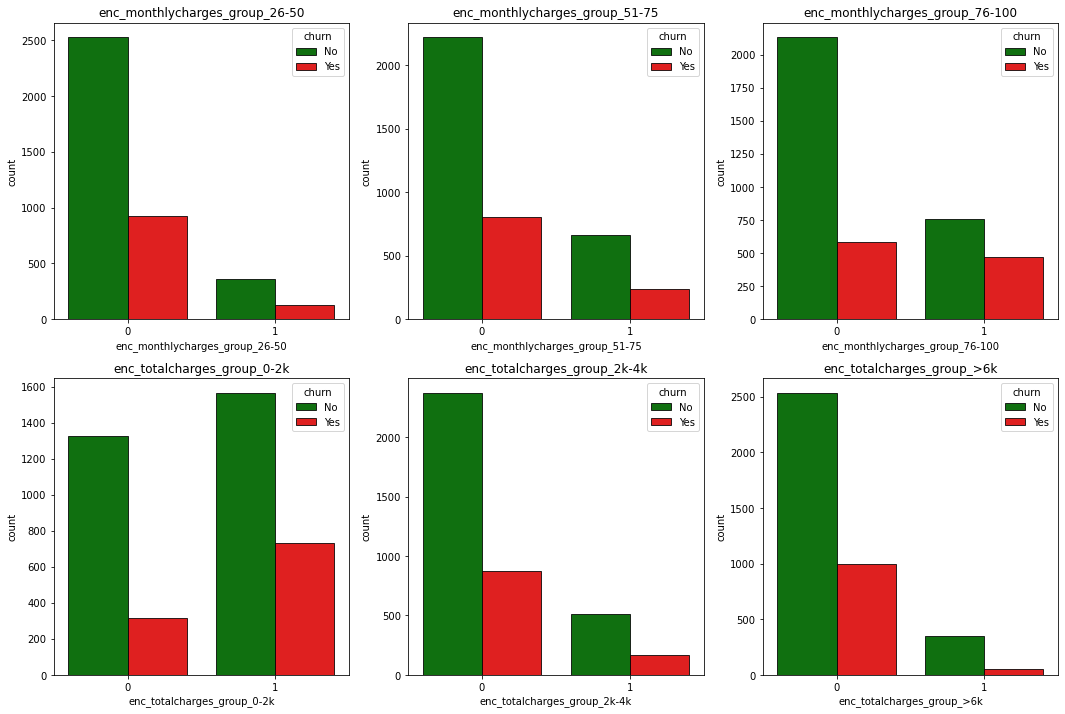

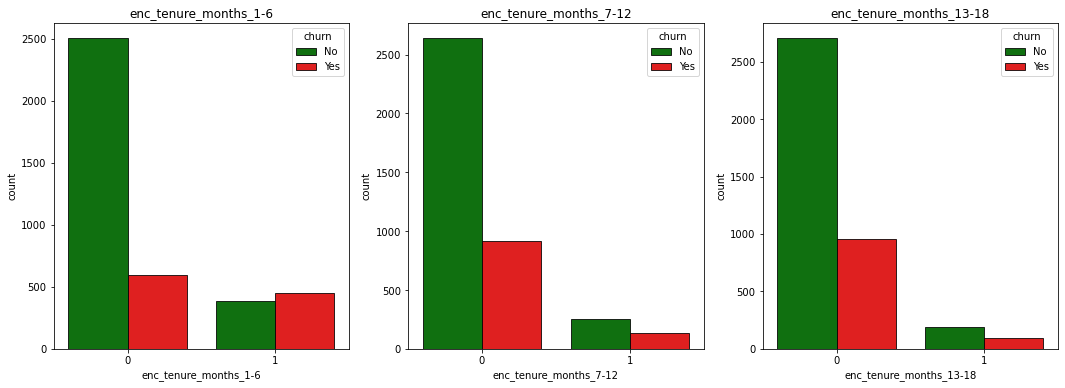

In [8]:
print(f" {countplot('churn', ['online_security_No', 'online_backup_No', 'device_protection_No','tech_support_No', 'streaming_tv_No', 'streaming_movies_No'], train)}")
print(f" {countplot('churn', ['enc_monthlycharges_group_26-50', 'enc_monthlycharges_group_51-75', 'enc_monthlycharges_group_76-100', 'enc_totalcharges_group_0-2k', 'enc_totalcharges_group_2k-4k', 'enc_totalcharges_group_>6k'], train)}")
print(f" {countplot('churn', ['enc_tenure_months_1-6', 'enc_tenure_months_7-12', 'enc_tenure_months_13-18'], train)}")
print(f' I used this as an overview to assess which ones I wish to look more closely at')

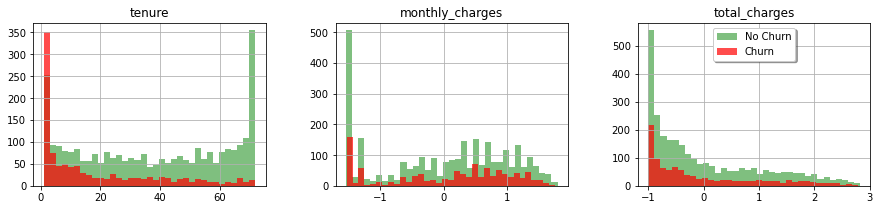

In [94]:
num_cols = ['tenure', 'monthly_charges', 'total_charges']

# look at distributions of numerical features in relation to the target variable
# it seems that as totalcharges and tenure increase, the likelihood of churn lessens.

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
train[train.churn_encoded == 0][num_cols].hist(bins=35, color="green", alpha=0.5, ax=ax)
train[train.churn_encoded == 1][num_cols].hist(bins=35, color="red", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=9)

# scaling has definitely helped with the axes. Future models may be interesting. 

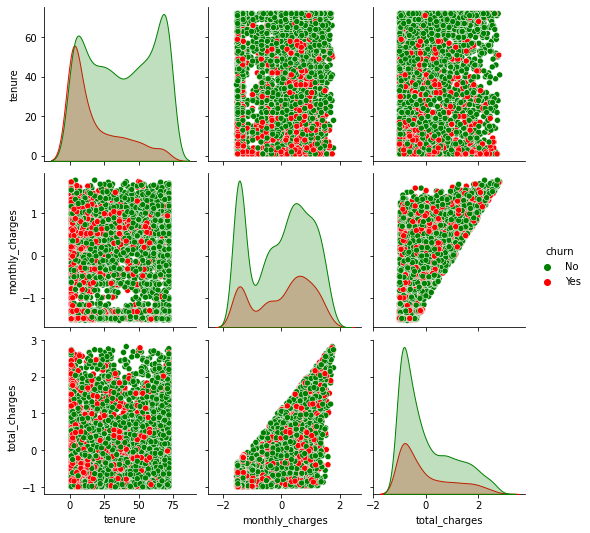

In [95]:
#Multivariate
# create and display a pairplot comparing the distributions of each quantitative variable
    # in each category of the target variable
target = 'churn'
g = sns.pairplot(train[num_cols + [target]], hue=target, palette=['#008000','#FF0000'])
plt.show()

<AxesSubplot:title={'center':'Features Correlated with Churn'}>

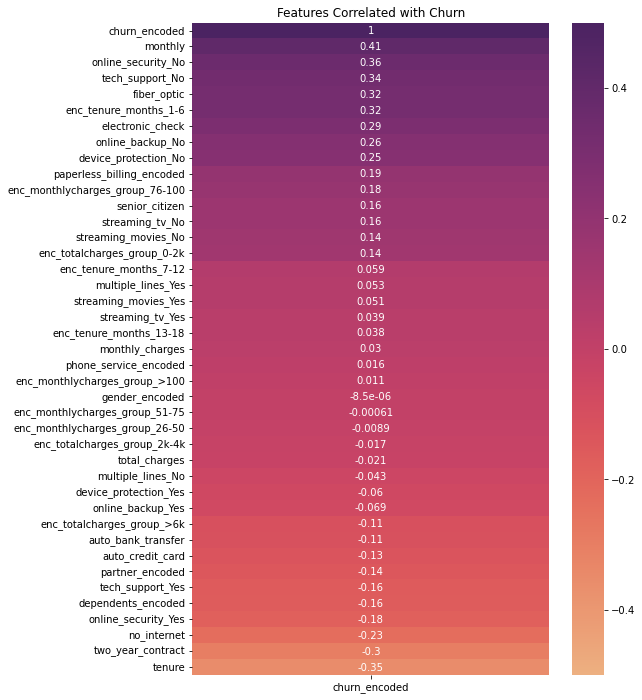

In [4]:
get_churn_heatmap(train)

### Hypothesis Building
- Looking at the features included in data and connecting them to their potential influence on customer churn, the following hypotheses can be made:
  - The longer the contract duration the less likely it is that the customer will churn as he/she is less frequently confronted with the potential termination decision. Perhaps the penalty for breaking contract would be beyond consideration. 
  - Customers, as long as they are internet users, are willing to cancel simple contracts with few associated product components quicker and more often than more complex bundles — perhaps customers value the reduced administrative complexity. They might also be hesitant to cancel a contract, when they depend on the additional service components (e.g. security packages).
  - Electronic checks are essentially proportional to the other payment methods and yet are inordinately more likely to churn. This may be consequential of the payment process being more difficult than intended or assume. 
  - Fiber optics enjoy a simple majority among clientele, but much like electronic checks, considerably overshadow the other options in terms of churn. Perhaps there is a link between the two, as well. 

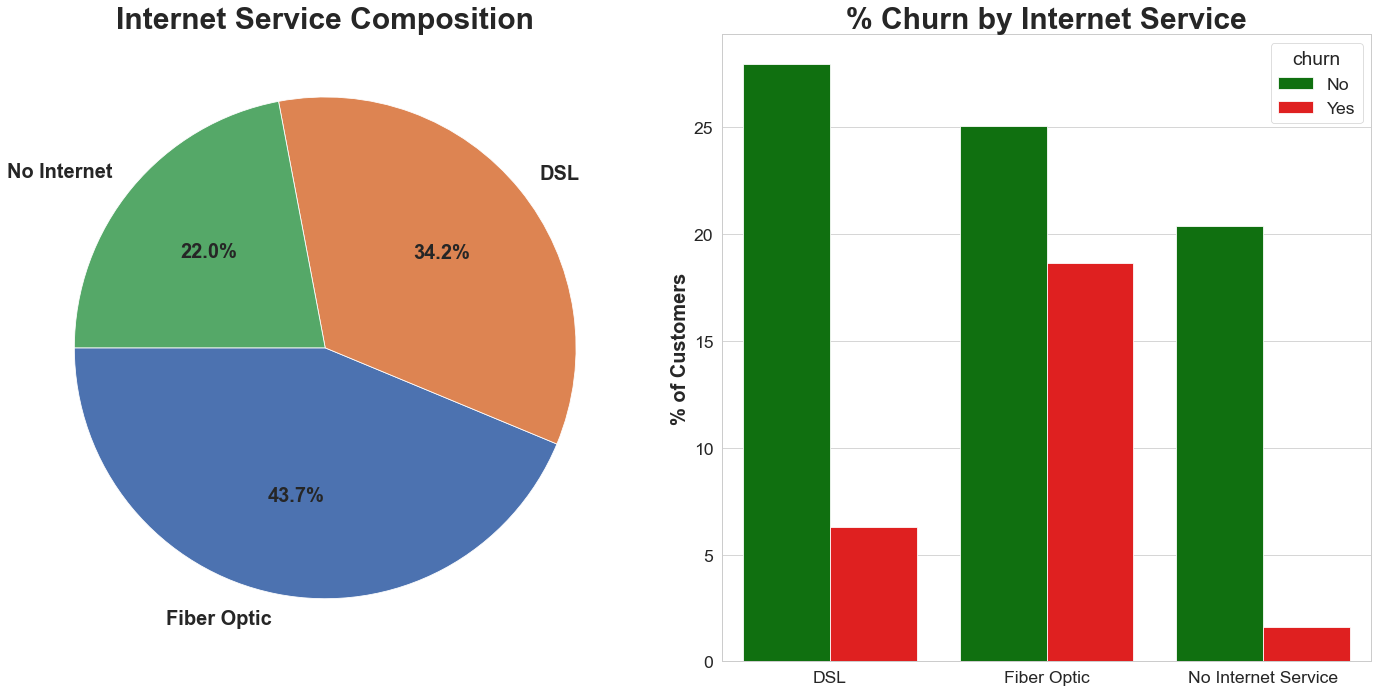

In [6]:
plot_internet_services(train)

- $H_0$: A customer's internet service type is independent of their potential for churn.
- $H_A$: Internet Service Type and Churn have some interplay, and churn may even depend upon this feature.. 

In [8]:
chi2_test(train.churn, train.internet_service_type)

Observed

[[1101  987  803]
 [ 247  735   64]]
---
Expected

[[ 989.9 1264.5  636.7]
 [ 358.1  457.5  230.3]]
---

chi^2 = 439.7661
p     = 0.0000

Reject H0


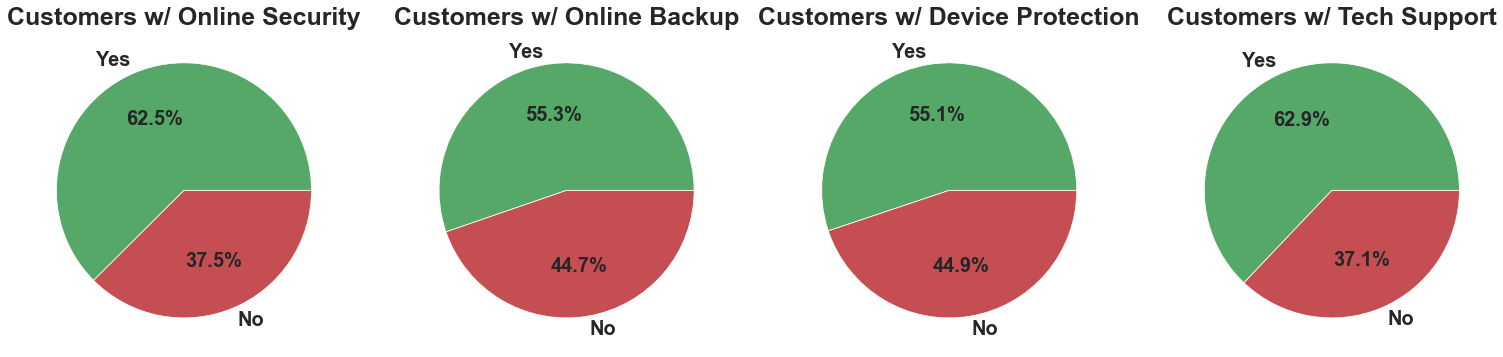

In [13]:
plot_services(train)

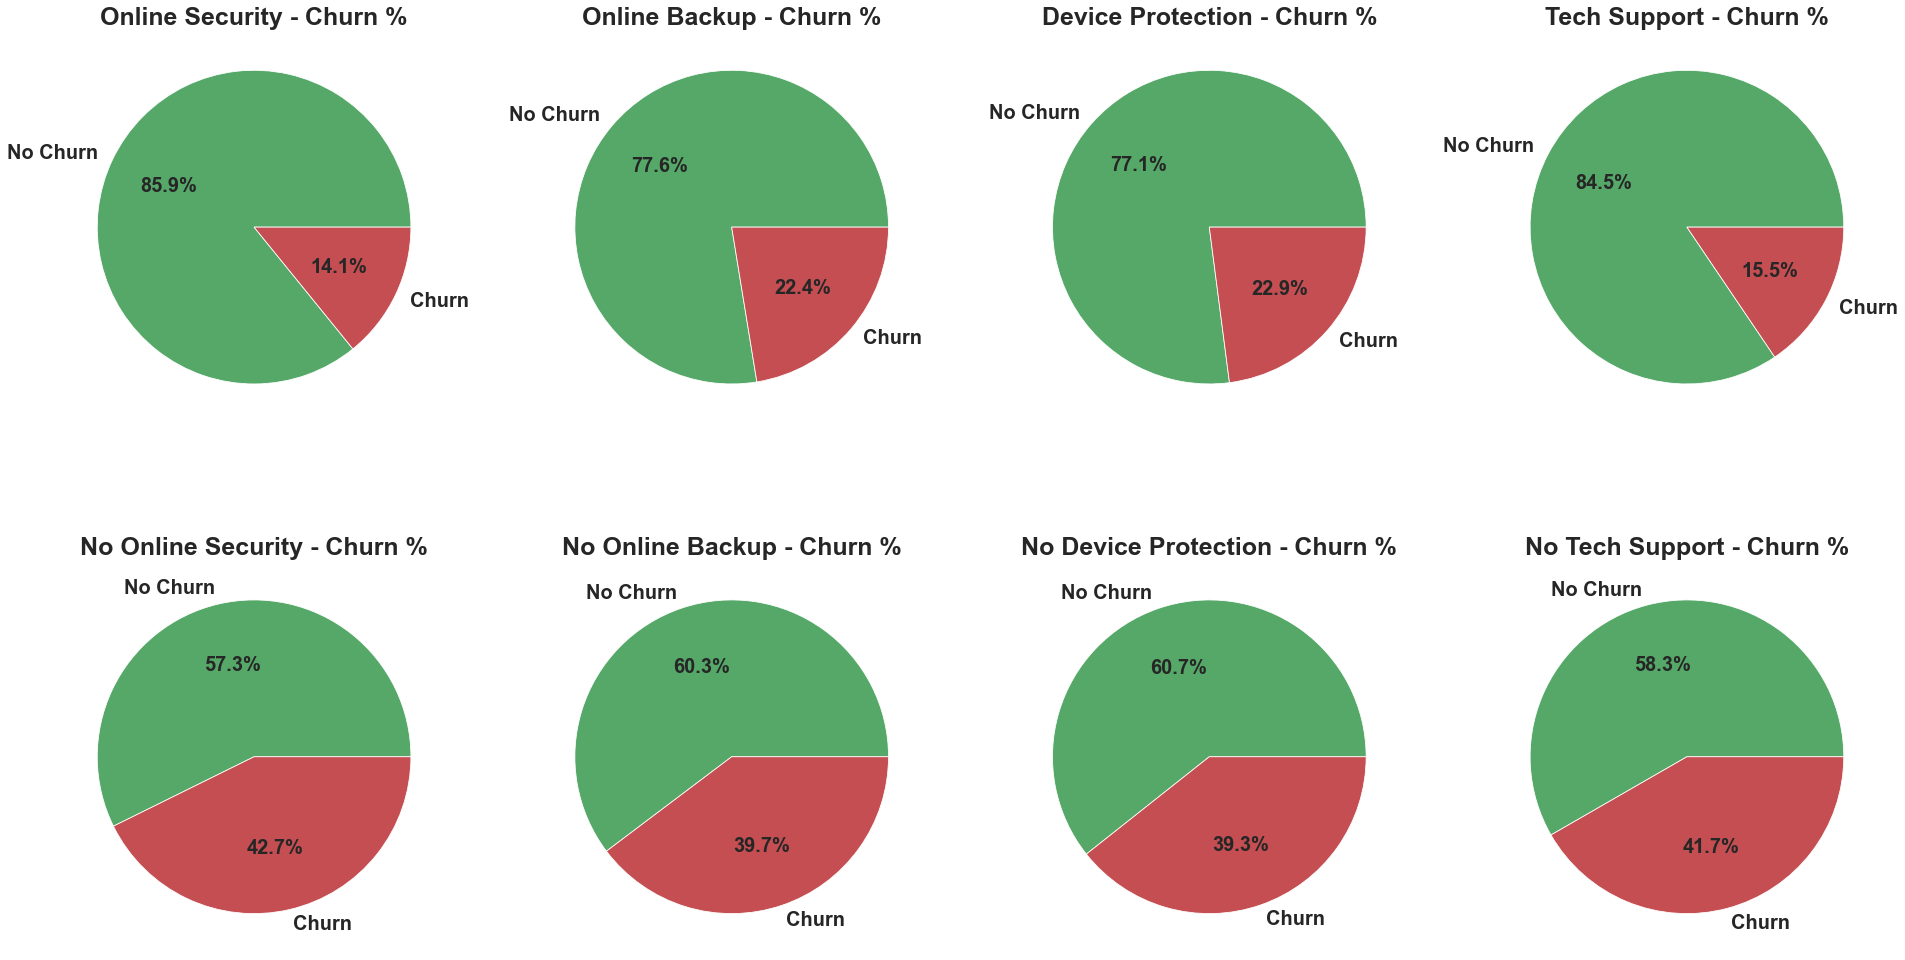

In [14]:
plot_services_churn(train)

- $H_0$: A customer's additional services is independent of their potential for churn.
- $H_A$: Additional services and Churn have some interplay, and churn may even depend upon this feature. 

In [10]:
chi2_test(train.churn, train.online_security)

Observed

[[1099  803  989]
 [ 819   64  163]]
---
Expected

[[1408.4  636.7  845.9]
 [ 509.6  230.3  306.1]]
---

chi^2 = 510.5206
p     = 0.0000

Reject H0


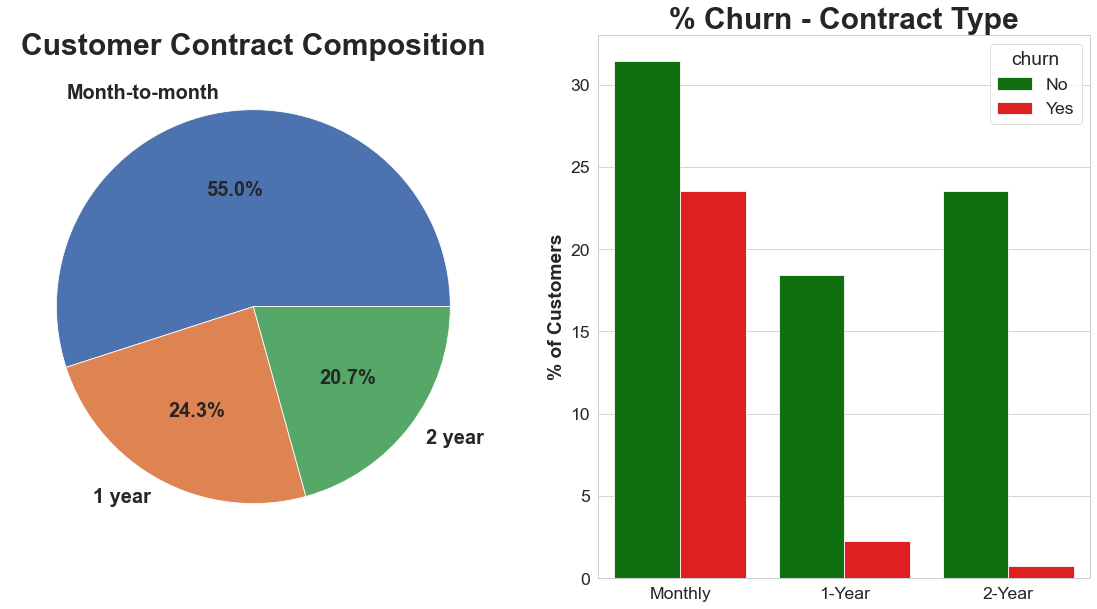

In [15]:
plot_contracts(train)

- $H_0$: Whether or not a customer is bound by contract is independent of their potential for churn.
- $H_A$: Contract or the lackthereof significantly influences churn. 

In [11]:
chi2_test(train.churn, train.contract_type)

Observed

[[1238  726  927]
 [ 927   89   30]]
---
Expected

[[1589.8  598.5  702.7]
 [ 575.2  216.5  254.3]]
---

chi^2 = 664.6572
p     = 0.0000

Reject H0


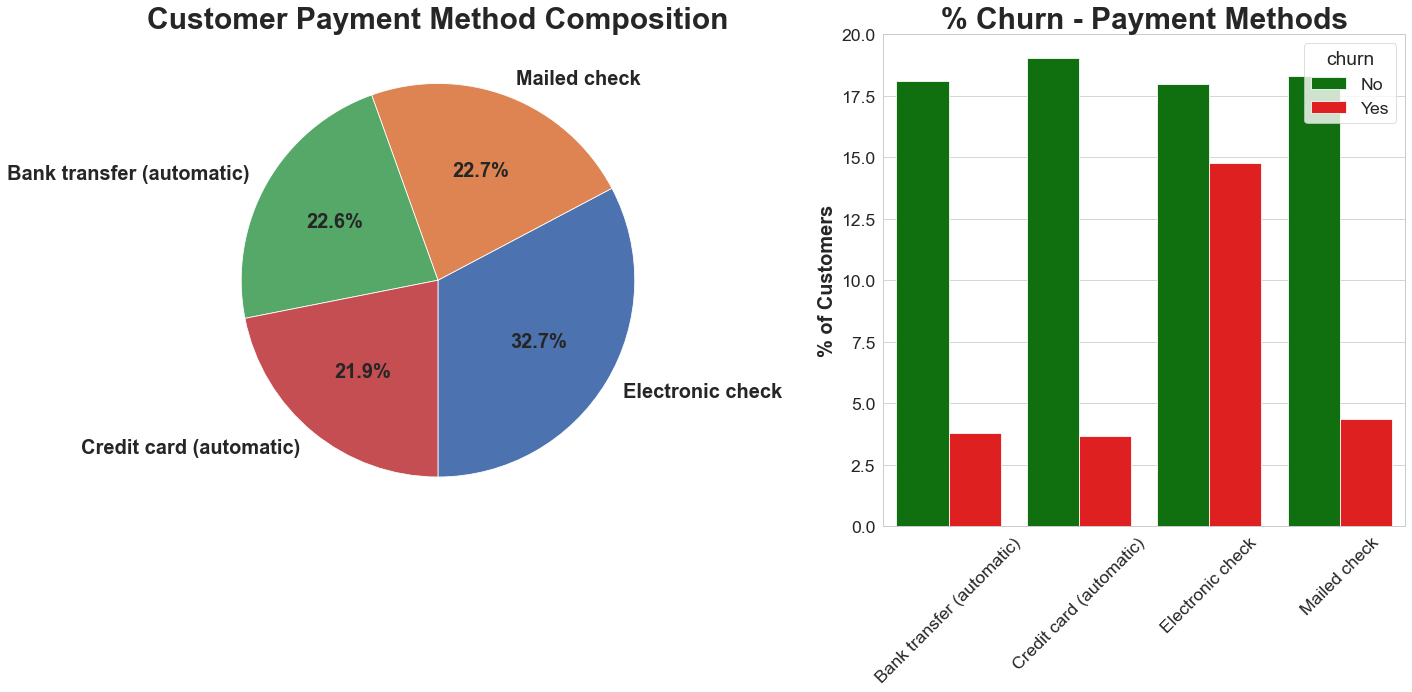

In [16]:
plot_pay_methods(train)

- $H_0$: There is not a significant connection between payment type and churn rates.
- $H_A$: Non-automatic payment types churn in greater quantities 

In [12]:
chi2_test(train.churn, train.payment_type)

Observed

[[713 750 708 720]
 [149 145 581 171]]
---
Expected

[[633.  657.2 946.5 654.3]
 [229.  237.8 342.5 236.7]]
---

chi^2 = 338.4852
p     = 0.0000

Reject H0


## Stage Four: Modeling

We've established what the most likely drivers of churn are. Now is the time create machine learning models which would allow us to identify the customers who are likely to churn, given these factors, and with some intervention we just might be able to keep them on board. 

Recall is suitable to this end, as there are worse revenue losses to having a lapse by losing a customer as opposed to retaining those who already in our system. After specifying our most pertinent features, and attributing them to the X_train and X_validate, while the dependent target variable was fixed to the y_train and y_validate, three models were created in an effort to capture the highest recall rate available under this framework:

1. A decision tree model. 58% Recall
2. A random forest model. 47% Recall
3. A k-nearest neighbors model. 56% Recall

Among all three the training and validate scores were greater than the baseline accuracy at about 80% a piece, making each of them suitable for careful consideration. 

In [14]:
features = [
    'monthly', 'two_year_contract', 'fiber_optic', 'electronic_check',
    'enc_tenure_months_1-6', 'enc_tenure_months_7-12', 'enc_tenure_months_13-18',
    'auto_credit_card', 'auto_bank_transfer', 'no_internet',
    'online_security_No', 'online_security_Yes', 'online_backup_No', 'online_backup_Yes',
    'device_protection_No', 'device_protection_Yes', 'tech_support_No', 'tech_support_Yes'   
]

X_train, y_train = train[features], train.churn_encoded
X_validate, y_validate = validate[features], validate.churn_encoded

In [15]:
baseline, baseline_pred = baseline_model(X_train, y_train)


               Baseline Accuracy Score: 73.43%
        First Ten Baseline Predictions: [0 0 0 0 0 0 0 0 0 0]
        


In [53]:
print('----------Decision Tree--------')
print(f'{model_metrics(X_train, y_train, y_pred)}')
print(f'accuracy score is {round(accuracy_score(y_train, y_pred),2)}')

----------Decision Tree--------
Number of true negatives  (tn) = 2571 
 The True Negative Rate (tnr) is: 0.889 

Number of true positives  (tp) = 603 
 The True Positive Rate (tpr) is:  0.576 

Number of false negatives (fn) = 443 
 The False Negative Rate (tpr) is: 0.424 

Number of false positives (fp) = 320 
 The False Positive Rate (tpr) is: 0.111 

              precision    recall  f1-score      support
0              0.853019  0.889312  0.870787  2891.000000
1              0.653304  0.576482  0.612494  1046.000000
accuracy       0.806198  0.806198  0.806198     0.806198
macro avg      0.753162  0.732897  0.741641  3937.000000
weighted avg   0.799958  0.806198  0.802163  3937.000000
accuracy score is 0.81


In [57]:
print('----------Random Forest---------')
print(f'{model_metrics(X_train, y_train, y_pred2)}')
print(f'accuracy score is {round(accuracy_score(y_train, y_pred2),2)}')

----------Random Forest---------
Number of true negatives  (tn) = 2656 
 The True Negative Rate (tnr) is: 0.919 

Number of true positives  (tp) = 495 
 The True Positive Rate (tpr) is:  0.473 

Number of false negatives (fn) = 551 
 The False Negative Rate (tpr) is: 0.527 

Number of false positives (fp) = 235 
 The False Positive Rate (tpr) is: 0.0813 

              precision    recall  f1-score      support
0              0.828188  0.918713  0.871105  2891.000000
1              0.678082  0.473231  0.557432  1046.000000
accuracy       0.800356  0.800356  0.800356     0.800356
macro avg      0.753135  0.695972  0.714269  3937.000000
weighted avg   0.788307  0.800356  0.787767  3937.000000
accuracy score is 0.8


In [58]:
print('----------K-Nearest Neighbors---------')
print(f'{model_metrics(X_train, y_train, y_pred3)}')
print(f'accuracy score is {round(accuracy_score(y_train, y_pred3),2)}')

----------K-Nearest Neighbors---------
Number of true negatives  (tn) = 2605 
 The True Negative Rate (tnr) is: 0.901 

Number of true positives  (tp) = 585 
 The True Positive Rate (tpr) is:  0.559 

Number of false negatives (fn) = 461 
 The False Negative Rate (tpr) is: 0.441 

Number of false positives (fp) = 286 
 The False Positive Rate (tpr) is: 0.0989 

              precision    recall  f1-score      support
0              0.849641  0.901072  0.874601  2891.000000
1              0.671642  0.559273  0.610329  1046.000000
accuracy       0.810262  0.810262  0.810262     0.810262
macro avg      0.760642  0.730173  0.742465  3937.000000
weighted avg   0.802350  0.810262  0.804388  3937.000000
accuracy score is 0.81


In [60]:
# Final Test

# re-creating the model using the given features and hyperparameters

# separate each sample into x (features) and y (target)
x_train = train[features]
y_train = train.churn_encoded

x_test = test[features]
y_test = test.churn_encoded

# create the classifier

# Best working KNN
clf = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = 6, min_samples_leaf = 1,
                              min_samples_split = 30)


# fit the classifier to the training data
clf = clf.fit(x_train, y_train)

# create predictions for the model's performance on the test set
y_pred = clf.predict(x_test)

# establish the probability for those predictions created above
y_pred_proba = clf.predict_proba(x_test)[:,1]

print('model accuracy: ', accuracy_score(y_test, y_pred))


model accuracy:  0.7837677725118484


# Conclusion
The data science pipeline has given us insight, and since it was not shutdown (completely) along the way, we learned about significant impacts on churn all without raising gas prices. Those who utilize our internet connections but decline our additional services such as tech_support are at high risk for churning; if it is the case that these services are unavailable or more expensive to those who are not on contract, then we must examine alternatives.

Fun little factoid: it has been known for quite some time that if a person has the knowledge of how to tap into a fiber optics network, they can easily do so. If the security attacker can access the physical fiber optic cable, they can retrieve the packets sent in the connection. The attackers can tamper with the information and have access to delicate information. Who's to say that the last year has not been plagued by a malicious agent?

We also are not given adequate information location to determine whether or not the key service area is one where contract-work is common. If we are in an area where it is not uncommon for someone to work in 6 month incremements, then tenure itself would come as no surprise.  

### Given more time I would
create more grouped columns and datframes that capture in particular internet users exclusively, examining it along demographic lines that were not necessarily valid or interesting when considered on the whole, such as among single users. I would also like to know how often tech_support has to render their services and if that is indicative of faultiness in the integrity of our fiber optic channels. 